In [1]:

%matplotlib inline

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
import pickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random


# Section 1: Load Dataset

In [2]:
# Section 1: Load Dataset
image_dir = "E:\sem6\Deep Learning\Project\Images\Images"
captions_file = "E:\sem6\Deep Learning\Project\captions.txt"

def load_captions(filepath):
    captions_dict = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split(',', 1)
            if len(parts) < 2:
                continue
            image_id, caption = parts
            image_id = image_id.strip()
            if image_id not in captions_dict:
                captions_dict[image_id] = []
            captions_dict[image_id].append("startseq " + caption.strip() + " endseq")
    if not captions_dict:
        raise ValueError("No captions were loaded. Check the captions file format.")
    return captions_dict

captions_dict = load_captions(captions_file)
print(f"Total images with captions: {len(captions_dict)}")

Total images with captions: 8091


# Section 2: Extract Features using InceptionV3 (CNN)

In [3]:
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

def extract_features(image_path, model):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    feature = model.predict(img, verbose=0)
    return feature

image_features = {}
for img_name in tqdm(os.listdir(image_dir), desc="Extracting image features"):
    img_path = os.path.join(image_dir, img_name)
    image_features[img_name] = extract_features(img_path, base_model).flatten()

with open("image_features.pkl", "wb") as f:
    pickle.dump(image_features, f)


Extracting image features: 100%|██████████| 8090/8090 [23:16<00:00,  5.79it/s]


In [6]:
import pickle

with open("image_features.pkl", "wb") as f:
    pickle.dump(image_features, f)

print("Features saved to image_features.pkl")


Features saved to image_features.pkl


In [ ]:
import pickle

# Load the saved image features
with open("image_features.pkl", "rb") as f:
    image_features = pickle.load(f)

print("Features loaded successfully!")
print(f"Number of images loaded: {len(image_features)}")


# Section 3: Tokenization of Captions

In [7]:
tokenizer = Tokenizer()
all_captions = [caption for captions in captions_dict.values() for caption in captions]
if not all_captions:
    raise ValueError("No captions found. Ensure the captions file is formatted correctly.")

tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print(f"Total captions loaded: {len(all_captions)}")
print(f"Vocabulary size: {vocab_size}")

Total captions loaded: 40455
Vocabulary size: 8496


# Section 4: Create Sequences for Training

In [8]:
max_length = max(len(caption.split()) for caption in all_captions)
print(f"Max caption length: {max_length}")

input_sequences = []
output_words = []
image_inputs = []
image_filenames = []

for img_id, captions in captions_dict.items():
    if img_id not in image_features:
        continue
    for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(seq)):
            input_sequences.append(seq[:i])
            output_words.append(seq[i])
            image_inputs.append(image_features[img_id])
            image_filenames.append(img_id)

input_sequences = pad_sequences(input_sequences, maxlen=max_length, padding='post')
output_words = np.array(output_words)
image_inputs = np.vstack(image_inputs)

Max caption length: 40


# Section 5: Split Dataset

In [9]:
X_train_img, X_test_img, X_train_seq, X_test_seq, y_train, y_test, train_names, test_names = train_test_split(
    image_inputs, input_sequences, output_words, image_filenames, test_size=0.2, random_state=42)


# Section 6: Define CNN-LSTM Model

In [10]:
embedding_dim = 256

inputs_img = Input(shape=(2048,))
dense_layer = Dense(embedding_dim, activation='relu')(inputs_img)

inputs_txt = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs_txt)
lstm_layer = LSTM(256)(embedding_layer)

merged = tf.keras.layers.add([dense_layer, lstm_layer])
dense_output = Dense(vocab_size, activation='softmax')(merged)

model = Model(inputs=[inputs_img, inputs_txt], outputs=dense_output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 256)   │  2,174,976 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 40)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8496)      │  2,183,472 │ add[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,408,304 (20.63 MB)

 Trainable params: 5,408,304 (20.63 MB)

 Non-trainable params: 0 (0.00 B)

# Section 7: Train the Model

In [11]:
history = model.fit([X_train_img, X_train_seq], y_train, 
                    validation_data=([X_test_img, X_test_seq], y_test), 
                    batch_size=64, epochs=10, verbose=1)

Epoch 1/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 1012s 143ms/step - accuracy: 0.3089 - loss: 4.0045 - val_accuracy: 0.3858 - val_loss: 3.1076
Epoch 2/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 756s 126ms/step - accuracy: 0.4009 - loss: 2.8699 - val_accuracy: 0.4040 - val_loss: 2.9708
Epoch 3/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 792s 133ms/step - accuracy: 0.4272 - loss: 2.5676 - val_accuracy: 0.4073 - val_loss: 2.9562
Epoch 4/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 796s 133ms/step - accuracy: 0.4502 - loss: 2.3564 - val_accuracy: 0.4092 - val_loss: 2.9494
Epoch 5/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 831s 139ms/step - accuracy: 0.4705 - loss: 2.1983 - val_accuracy: 0.4080 - val_loss: 3.0007
Epoch 6/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 769s 129ms/step - accuracy: 0.4921 - loss: 2.0650 - val_accuracy: 0.4065 - val_loss: 3.0191
Epoch 7/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 777s 130ms/step - accuracy: 0.5122 - loss: 1.9446 - val_accuracy: 0.4024 - val_loss: 3.0817
Epoch 8/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 766s 128ms/step - a

In [12]:
# 1. Save the trained model
model.save("caption_model.h5")
print("Model saved as caption_model.h5")

# 2. Save the training history
import pickle

with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("Training history saved as training_history.pkl")


Model saved as caption_model.h5
Training history saved as training_history.pkl


In [ ]:
# 1. Load the trained model
from tensorflow.keras.models import load_model

model = load_model("caption_model.h5")
print("Model loaded successfully.")

# 2. Load the training history
import pickle

with open("training_history.pkl", "rb") as f:
    history = pickle.load(f)

print("Training history loaded successfully.")


# Section 7.1: Plot Accuracy & Loss

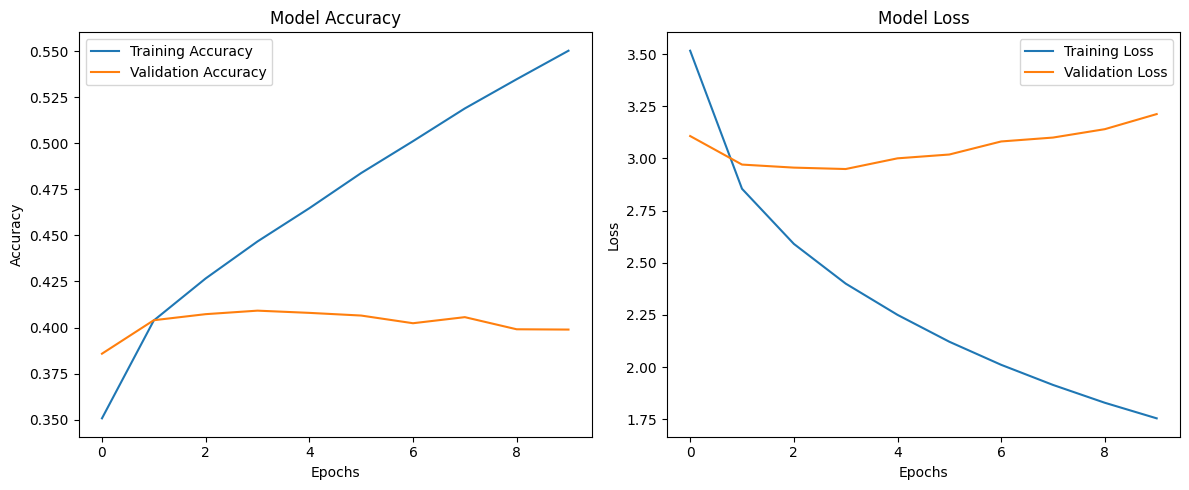

Final Training Accuracy: 0.5502
Final Validation Accuracy: 0.3989


In [13]:

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

plot_training_history(history)


# Section 8: Save Model and Training History

In [14]:
model.save("image_caption_generator.keras")

with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)



# Section 9: Generate Caption

In [15]:
def generate_caption(image_path, model, tokenizer, max_length):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    feature = extract_features(image_path, base_model).flatten()
    caption = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        y_pred = model.predict([feature.reshape(1, -1), sequence], verbose=0)
        word_index = np.argmax(y_pred)
        word = tokenizer.index_word.get(word_index, '')
        if word == "endseq" or word == '':
            break
        caption += ' ' + word
    return caption.replace('startseq', '').replace('endseq', '').strip()

# Section 10: Show Random Test Image & Generated Caption

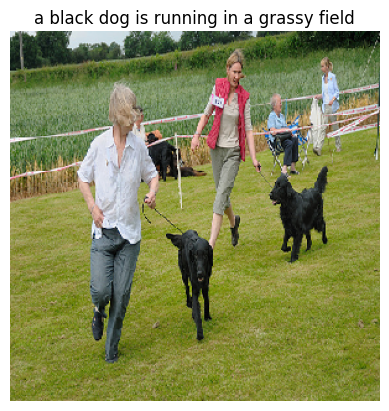

In [52]:
test_image_name = random.choice(os.listdir(image_dir))
image_path = os.path.join(image_dir, test_image_name)

img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
plt.imshow(img)
plt.axis("off")
caption = generate_caption(image_path, model, tokenizer, max_length)
plt.title(caption)
plt.show()

# Basic hyperparameter grid search (manual tuning)

In [21]:

embedding_dims = [128, 256]
lstm_units_list = [128, 256]
learning_rates = [0.001, 0.0005]

best_val_acc = 0
best_model = None
best_params = {}

for embed_dim in embedding_dims:
    for lstm_units in lstm_units_list:
        for lr in learning_rates:
            print(f"\nTraining with Embedding: {embed_dim}, LSTM: {lstm_units}, LR: {lr}")
            
            # Image input
            inputs_img = Input(shape=(2048,))
            dense_layer = Dense(embed_dim, activation='relu')(inputs_img)

            # Text input
            inputs_txt = Input(shape=(max_length,))
            embedding_layer = Embedding(vocab_size, embed_dim, mask_zero=True)(inputs_txt)
            lstm_layer = LSTM(lstm_units)(embedding_layer)

            # Merge with Concatenate
            merged = tf.keras.layers.Concatenate()([dense_layer, lstm_layer])
            output = Dense(vocab_size, activation='softmax')(merged)

            model = Model(inputs=[inputs_img, inputs_txt], outputs=output)
            model.compile(loss='sparse_categorical_crossentropy',
                          optimizer=Adam(learning_rate=lr),
                          metrics=['accuracy'])

            history = model.fit([X_train_img, X_train_seq], y_train,
                                validation_data=([X_test_img, X_test_seq], y_test),
                                epochs=5, batch_size=64, verbose=0)

            val_acc = history.history['val_accuracy'][-1]
            print(f"Validation Accuracy: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = model
                best_params = {
                    'embedding_dim': embed_dim,
                    'lstm_units': lstm_units,
                    'learning_rate': lr
                }

print("\nBest Parameters:", best_params)




Training with Embedding: 128, LSTM: 128, LR: 0.001
Validation Accuracy: 0.3975

Training with Embedding: 128, LSTM: 128, LR: 0.0005
Validation Accuracy: 0.4100

Training with Embedding: 128, LSTM: 256, LR: 0.001
Validation Accuracy: 0.3954

Training with Embedding: 128, LSTM: 256, LR: 0.0005
Validation Accuracy: 0.4125

Training with Embedding: 256, LSTM: 128, LR: 0.001
Validation Accuracy: 0.3972

Training with Embedding: 256, LSTM: 128, LR: 0.0005
Validation Accuracy: 0.4136

Training with Embedding: 256, LSTM: 256, LR: 0.001
Validation Accuracy: 0.4010

Training with Embedding: 256, LSTM: 256, LR: 0.0005
Validation Accuracy: 0.4160

Best Parameters: {'embedding_dim': 256, 'lstm_units': 256, 'learning_rate': 0.0005}


In [22]:
# === Save the best model ===
best_model.save("best_caption_model.h5")

# === Save best parameters ===
import pickle
with open("best_params.pkl", "wb") as f:
    pickle.dump(best_params, f)

print("✅ Model and parameters saved.")


✅ Model and parameters saved.


In [ ]:
from tensorflow.keras.models import load_model
import pickle

# === Load the model ===
best_model = load_model("best_caption_model.h5")

# === Load the best parameters ===
with open("best_params.pkl", "rb") as f:
    best_params = pickle.load(f)

print("✅ Model and parameters loaded.")
print("Best Parameters:", best_params)


#loading the best model, evaluating it using BLEU score, and visualizing some predictions.

In [26]:
best_model.save("best_caption_model.keras")


In [27]:
best_model = load_model("best_caption_model.keras")


e:\Caption generate\tf-env\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [29]:
!pip install nltk



   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 985.5 kB/s eta 0:00:01
   ------------- -------------------------- 0.5/1.5 MB 985.5 kB/s eta 0:00:01
   ------------- -------------------------- 0.5/1.5 MB 985.5 kB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.5 MB 657.8 kB/s eta 0:00:02
   --------------------------- ------------ 1.0/1.5 MB 838.4 kB/s eta 0:00:01
   ---------------------------------- ----- 1.3/1.5 MB 894.7 kB/s eta 0:00:01
   ---------------------------------- ----- 1.3/1.5 MB 894.7 kB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 743.6 kB/s eta 0:00:00


In [30]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


In [31]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Himal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [32]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
import os

def evaluate_model(model, tokenizer, max_length, test_imgs, captions_dict, image_dir):
    actual, predicted = [], []

    for img_name in test_imgs[:50]:  # Evaluate on 50 test images
        img_path = os.path.join(image_dir, img_name)
        true_caps = captions_dict.get(img_name, [])

        pred_cap = generate_caption(img_path, model, tokenizer, max_length)

        # Clean captions
        actual.append([cap.split()[1:-1] for cap in true_caps])  # Remove startseq & endseq
        predicted.append(pred_cap.split())

    # BLEU score with smoothing
    smooth = SmoothingFunction().method1
    scores = [sentence_bleu(ref, pred, smoothing_function=smooth) for ref, pred in zip(actual, predicted)]
    avg_score = np.mean(scores)

    print(f"\n📊 Average BLEU Score on 50 test images: {avg_score:.4f}")
    return avg_score


In [34]:
!pip install opencv-python


  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)


In [36]:
import matplotlib.pyplot as plt
import cv2

def show_predictions(model, tokenizer, max_length, test_imgs, image_dir, num_samples=5):
    for img_name in test_imgs[:num_samples]:
        img_path = os.path.join(image_dir, img_name)
        caption = generate_caption(img_path, model, tokenizer, max_length)

        # Load and show image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Generated Caption:\n{caption}", fontsize=12)
        plt.show()


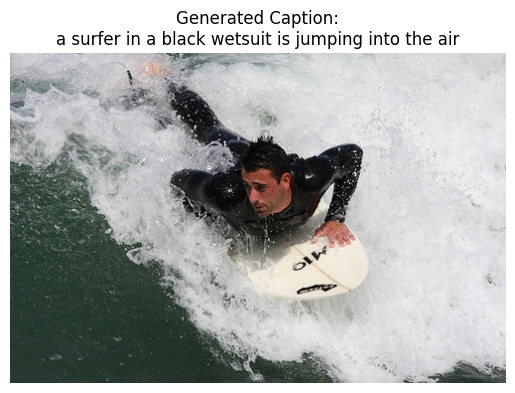

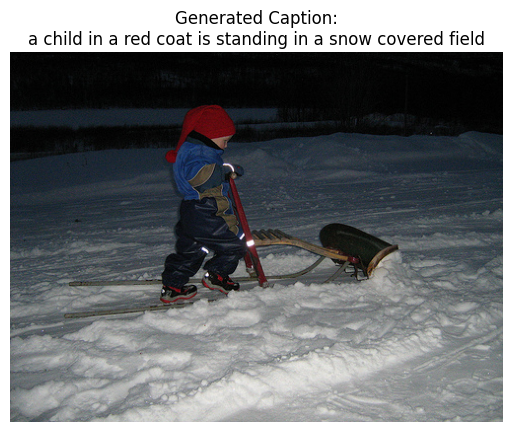

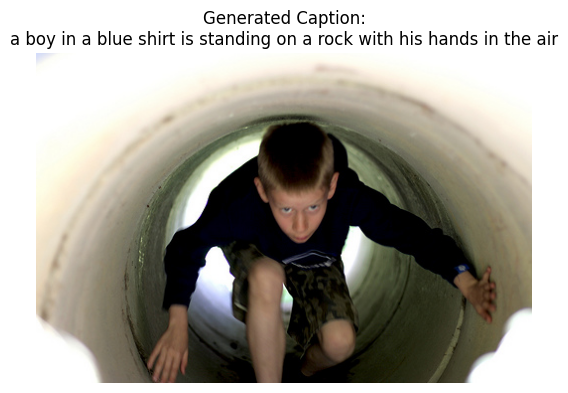

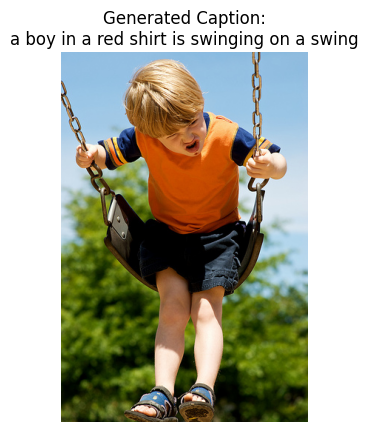

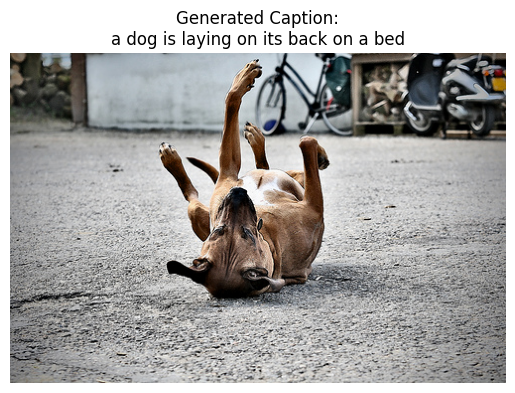

In [37]:
show_predictions(best_model, tokenizer, max_length, test_names, image_dir, num_samples=5)
